In [40]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from scheduler import Sampler
from tqdm.notebook import tqdm
from model import Diffusion
from transformers import AutoTokenizer
from safetensors.torch import load_file

### First Step is to Load Pretrained Model

We need to make sure the model structure we load is identical to the ones we trained with, so I define my variant below

In [12]:
### Load Model ###
model = Diffusion(in_channels=3, 
                  context_embed_dim=512, 
                  start_dim=128, 
                  dim_mults=(1,2,3,4), 
                  residual_blocks_per_group=2, 
                  groupnorm_num_groups=16, 
                  time_embed_dim=128, 
                  time_embed_dim_ratio=4)

### Load Pretrained Weights ###
path_to_model_weights = "work_dir/checkpoint/model.safetensors"
model_weights = load_file(path_to_model_weights)
model.load_state_dict(model_weights)

<All keys matched successfully>

### Load DDPM Sampler

We need to load the DDPM Sampler we used for Training as well!

In [16]:
ddpm_sampler = Sampler(total_timesteps=1000)

### Inference an Image with Text Prompt 

We need to also load the CLIP tokenizer that we used for Training

In [82]:
### Load tokenizer ###
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

### Generate Script ###
@torch.no_grad()
def sample_plot_images(prompts,
                       total_timesteps, 
                       sampler, 
                       image_size, 
                       num_channels, 
                       model,
                       device="cuda"):

    ### Create a Copy of the Text Prompts ###
    text_promps = prompts
    
    ### Get Number of Images to Generate ###
    num_gens = len(prompts)

    ### Place model on Device ###
    model = model.to(device)

    ### Tokenize Text ###
    tokenized = tokenizer(prompts, padding=True, return_tensors="pt")
    prompts = tokenized["input_ids"].to(device)
    mask = tokenized["attention_mask"].to(device)
    mask = ~mask.bool()

    ### Image Transformations ###
    tensor2image_transform = transforms.Compose([
        transforms.Lambda(lambda t: t.squeeze(0)),
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: torch.clamp(t, min=0, max=255)),
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    ### Random Noize to Generate From ###
    images = torch.randn((num_gens, num_channels, image_size, image_size))

    ### Iterate through all Denoising Steps ###
    for t in tqdm(np.arange(total_timesteps)[::-1]):
        ts = torch.full((num_gens, ), t)
        noise_pred = model(images.to(device), 
                           ts.to(device),
                           context=prompts,
                           mask=mask).detach().cpu()
        
        images = sampler.remove_noise(images, ts, noise_pred)

    gen_images = []
    for image in images:
        gen_images.append(tensor2image_transform(image))


    for image, prompt in zip(gen_images, text_promps):
        print("Input Prompt:", prompt)
        plt.figure(figsize=(6,6))
        plt.imshow(image)
        plt.axis("off")
        plt.show()
  
    return gen_images


  0%|          | 0/1000 [00:00<?, ?it/s]

Input Prompt: A red kite flying in the sky


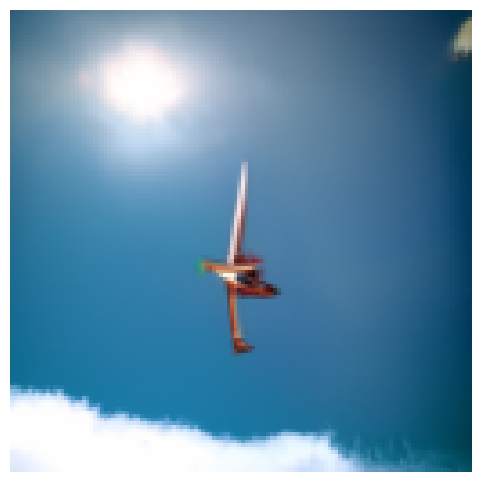

In [72]:
prompts = ["A red kite flying in the sky"]

gen_images = sample_plot_images(prompts=prompts,
                                total_timesteps=1000, 
                                sampler=ddpm_sampler, 
                                image_size=128,
                                num_channels=3,
                                model=model)

  0%|          | 0/1000 [00:00<?, ?it/s]

Input Prompt: A snowy mountain range with a beautiful sunny sky


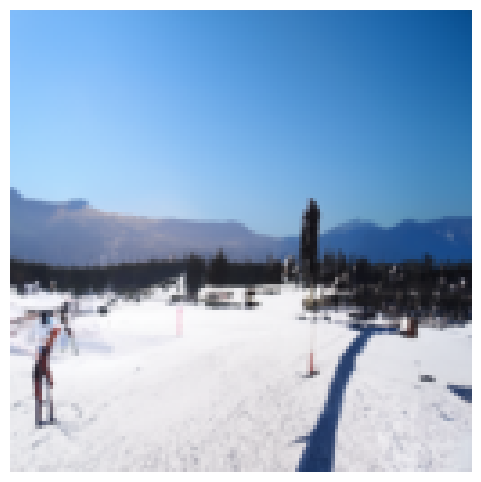

In [81]:
prompts = ["A snowy mountain range with a beautiful sunny sky"]

gen_images = sample_plot_images(prompts=prompts,
                                total_timesteps=1000, 
                                sampler=ddpm_sampler, 
                                image_size=128,
                                num_channels=3,
                                model=model)